In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


class GradCAM():
    """
    Class to implement the GradCam function with it's necessary Pytorch hooks.

    Attributes
    ----------
    model : detectron2 GeneralizedRCNN Model
        A model using the detectron2 API for inferencing
    layer_name : str
        name of the convolutional layer to perform GradCAM with
    """

    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.activations = None
        self.gradient = None
        self.model.eval()
        self.activations_grads = []
        self._register_hook()

    def _get_activations_hook(self, module, input, output):
        self.activations = output

    def _get_grads_hook(self, module, input_grad, output_grad):
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.model.named_modules():
            if name == self.target_layer_name:
                self.activations_grads.append(module.register_forward_hook(self._get_activations_hook))
                self.activations_grads.append(module.register_backward_hook(self._get_grads_hook))
                return True
        print(f"Layer {self.target_layer_name} not found in Model!")

    def _release_activations_grads(self):
      for handle in self.activations_grads:
            handle.remove()
    
    def _postprocess_cam(self, raw_cam, img_width, img_height):
        cam_orig = np.sum(raw_cam, axis=0)  # [H,W]
        cam_orig = np.maximum(cam_orig, 0)  # ReLU
        cam_orig -= np.min(cam_orig)
        cam_orig /= np.max(cam_orig)
        cam = cv2.resize(cam_orig, (img_width, img_height))
        return cam, cam_orig

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self._release_activations_grads()

    def __call__(self, inputs, target_category):
        """
        Calls the GradCAM++ instance

        Parameters
        ----------
        inputs : dict
            The input in the standard detectron2 model input format
            https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-input-format

        target_category : int, optional
            The target category index. If `None` the highest scoring class will be selected

        Returns
        -------
        cam : np.array()
          Gradient weighted class activation map
        output : list
          list of Instance objects representing the detectron2 model output
        """
        self.model.zero_grad()
        output = self.model.forward([inputs])

        if target_category == None:
          target_category =  np.argmax(output[0]['instances'].scores.cpu().data.numpy(), axis=-1)

        score = output[0]['instances'].scores[target_category]
        #box0 = output[0]['instances'].pred_boxes[0].tensor[0][target_category]
        #print(box0)
        #box0.backward()
        score.backward()

        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        activations = self.activations[0].cpu().data.numpy()  # [C,H,W]
        weight = np.mean(gradient, axis=(1, 2))  # [C]

        cam = activations * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam, cam_orig = self._postprocess_cam(cam, inputs["width"], inputs["height"])

        return cam, cam_orig, output

class GradCamPlusPlus(GradCAM):
    """
    Subclass to implement the GradCam++ function with it's necessary PyTorch hooks.
    ...

    Attributes
    ----------
    model : detectron2 GeneralizedRCNN Model
        A model using the detectron2 API for inferencing
    target_layer_name : str
        name of the convolutional layer to perform GradCAM++ with

    """
    def __init__(self, model, target_layer_name):
        super(GradCamPlusPlus, self).__init__(model, target_layer_name)

    def __call__(self, inputs, target_category):
        """
        Calls the GradCAM++ instance

        Parameters
        ----------
        inputs : dict
            The input in the standard detectron2 model input format
            https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-input-format

        target_category : int, optional
            The target category index. If `None` the highest scoring class will be selected

        Returns
        -------
        cam : np.array()
          Gradient weighted class activation map
        output : list
          list of Instance objects representing the detectron2 model output
        """
        self.model.zero_grad()
        output = self.model.forward([inputs])

        if target_category == None:
          target_category =  np.argmax(output[0]['instances'].scores.cpu().data.numpy(), axis=-1)

        score = output[0]['instances'].scores[target_category]
        score.backward()

        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        activations = self.activations[0].cpu().data.numpy()  # [C,H,W]

        #from https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/grad_cam_plusplus.py
        grads_power_2 = gradient**2
        grads_power_3 = grads_power_2 * gradient
        # Equation 19 in https://arxiv.org/abs/1710.11063
        sum_activations = np.sum(activations, axis=(1, 2))
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 +
                               sum_activations[:, None, None] * grads_power_3 + eps)
        # Now bring back the ReLU from eq.7 in the paper,
        # And zero out aijs where the activations are 0
        aij = np.where(gradient != 0, aij, 0)

        weights = np.maximum(gradient, 0) * aij
        weight = np.sum(weights, axis=(1, 2))

        cam = activations * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam, cam_orig = self._postprocess_cam(cam, inputs["width"], inputs["height"])

        return cam, cam_orig, output


In [2]:
import cv2
import detectron2.data.transforms as T
import numpy as np
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data.detection_utils import read_image
from detectron2.modeling import build_model

from torch import nn

class Detectron2GradCAM():
  """
      Attributes
    ----------
    config_file : str
        detectron2 model config file path
    model_file : str
        detectron2 model file path
    """
  def __init__(self, config_file, model_file):
      self.cfg = self._setup_cfg(config_file, model_file)

  def _setup_cfg(self, config_file, model_file):
      # load config from file, add your custom model config like RPN HEADS here
      cfg = get_cfg()
      cfg.merge_from_file(config_file)

      # cfg.DATALOADER.NUM_WORKERS = cfg_parms['NUM_WORKERS']
      # cfg.SOLVER.IMS_PER_BATCH = cfg_parms['IMS_PER_BATCH']
      # cfg.SOLVER.BASE_LR = cfg_parms['BASE_LR']
      # cfg.SOLVER.GAMMA = cfg_parms['GAMMA']
      # cfg.SOLVER.WARMUP_ITERS = cfg_parms['WARMUP_ITERS']
      cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(cfg_parms['BIRD_SPECIES'])
      # cfg.SOLVER.MAX_ITER = cfg_parms['MAX_ITER']
      # cfg.SOLVER.STEPS = cfg_parms['STEPS']
      # cfg.SOLVER.CHECKPOINT_PERIOD = cfg_parms['CHECKPOINT_PERIOD']
      # cfg.DATASETS.TRAIN = ("birds_species_Train",)

      # cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
      # cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
      cfg.MODEL.WEIGHTS = model_file
      cfg.MODEL.DEVICE = 'cpu'
      # if torch.cuda.is_available():
      #   cfg.MODEL.DEVICE = "cuda"
      # else:
      #   cfg.MODEL.DEVICE = "cpu"
      cfg.freeze()
      return cfg

  def _get_input_dict(self, original_image):
      height, width = original_image.shape[:2]
      transform_gen = T.ResizeShortestEdge(
          [self.cfg.INPUT.MIN_SIZE_TEST, self.cfg.INPUT.MIN_SIZE_TEST], self.cfg.INPUT.MAX_SIZE_TEST
      )
      image = transform_gen.get_transform(original_image).apply_image(original_image)
      image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1)).requires_grad_(True)
      inputs = {"image": image, "height": height, "width": width}
      return inputs

  def get_cam(self, img, target_instance, layer_name, grad_cam_type="GradCAM"):
      """
      Calls the GradCAM++ instance

      Parameters
      ----------
      img : str
          Path to inference image
      target_instance : int
          The target instance index
      layer_name : str
          Convolutional layer to perform GradCAM on
      grad_cam_type : str
          GradCAM or GradCAM++ (for multiple instances of the same object, GradCAM++ can be favorable)

      Returns
      -------
      image_dict : dict
        {"image" : <image>, "cam" : <cam>, "output" : <output>, "label" : <label>}
        <image> original input image
        <cam> class activation map resized to original image shape
        <output> instances object generated by the model
        <label> label of the 
      cam_orig : numpy.ndarray
        unprocessed raw cam
      """
      model = build_model(self.cfg)
      checkpointer = DetectionCheckpointer(model)
      checkpointer.load(self.cfg.MODEL.WEIGHTS)

      image = read_image(img, format="BGR")
      input_image_dict = self._get_input_dict(image)

      if grad_cam_type == "GradCAM":
        grad_cam = GradCAM(model, layer_name)

      elif grad_cam_type == "GradCAM++":
        grad_cam = GradCamPlusPlus(model, layer_name)
      
      else:
        raise ValueError('Grad CAM type not specified')

      with grad_cam as cam:
        cam, cam_orig, output = cam(input_image_dict, target_category=target_instance)

      image_dict = {}
      image_dict["image"] = image
      image_dict["cam"] = cam
      image_dict["output"] = output
      # image_dict["label"] = MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]).thing_classes[output[0]["instances"].pred_classes[target_instance]]
      image_dict["label"] = ['ROT', 'SAT', 'Unknown'][output[0]["instances"].pred_classes[target_instance]]

      return image_dict, cam_orig

In [3]:
cfg_parms = {'NUM_WORKERS': 0, 'IMS_PER_BATCH': 8, 'BASE_LR': .01931492350199079, 'GAMMA': 0.19953251054833593,
                 'WARMUP_ITERS': 1, 'MAX_ITER': 1600,
                 'STEPS': [899], 'CHECKPOINT_PERIOD': 899, 'output_dir': '/content/output',
                 'model_name': "faster_rcnn_R_50_FPN_1x", 'BIRD_SPECIES': ['ROT', 'SAT'], 'Custom': False}

# cfg.MODEL.WEIGHTS = "/model_final.pth"
# predictor = DefaultPredictor(cfg)

In [4]:
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
import matplotlib.patches as patches
import pandas as pd

colors = {'ROT':'r','SAT':'cyan','LAGUA':'w'}

"""
choose the object instance you want to perfrom GradCAM on. It's defined by `instance = 0`
"""

plt.rcParams["figure.figsize"] = (30,10)

# img = "/content/DJI_20220616111641_0223_12_9.JPEG"
img = './data/22F_new/split/Validate/20220521 - Chester Island 10k-05-11_12_5.JPEG'
config_file = model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")
# model_file = "/content/model_final.pth"
model_file = "./output/Training_models_terns/06_22_bay_tune_retina_2class_set_I_aug/faster_rcnn_R_50_FPN_1x-20221101-170256/model_final.pth"

layer_name = "backbone.bottom_up.res5.2.conv3"


cam_extractor = Detectron2GradCAM(config_file=config_file, model_file=model_file)

instance = 0 #CAM is generated per object instance, not per class!
im_grad = {'ROT':{},'SAT':{},'LAGUA':{}}
while True:
    try:
        image_dict, cam_orig = cam_extractor.get_cam(img=img, target_instance=instance, 
                                                     layer_name=layer_name, grad_cam_type="GradCAM++")
    except:
        break
    v = Visualizer(image_dict["image"], 
                   MetadataCatalog.get(f"birds_species_Validate"),
    #                MetadataCatalog.get(cam_extractor.cfg.DATASETS.TRAIN[0]), 
                   scale=1.0)
    #out = v.draw_instance_predictions(image_dict["output"][0]["instances"][instance].to("cpu"))
    im_grad[image_dict['label']][instance] = image_dict["cam"]
    instance += 1
    print(instance, end='\r')
    
im_cam = {k:np.array(list(grad.values())).mean(0) for k,grad in im_grad.items()}


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272168290/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/appuser/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


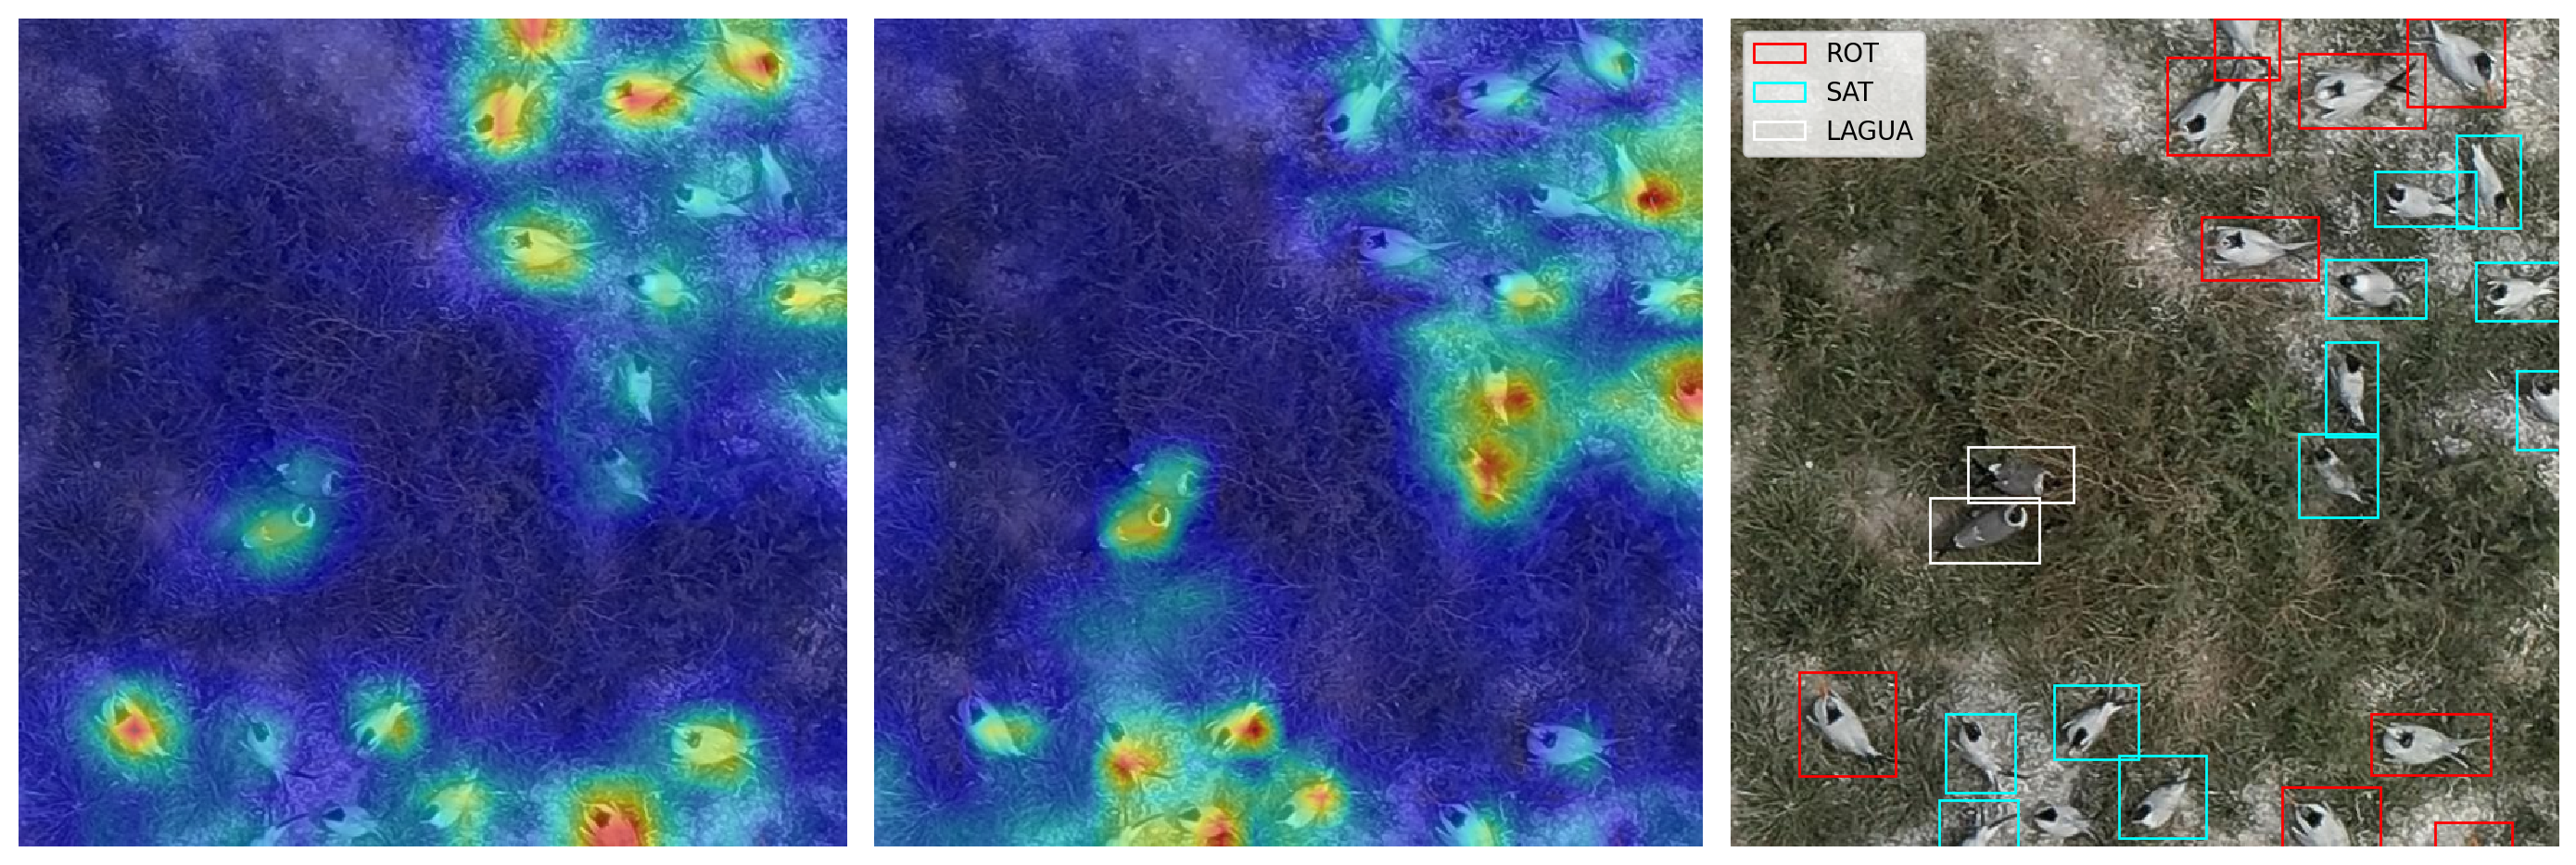

In [5]:

fig, axes = plt.subplots(1,3, dpi=200, figsize=(14,8))

ax = axes[-1]
im = cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2BGR) 
ax.imshow(im, interpolation='none')
ax.axis('off')
# ax.set_title(f"Original image tile with ground truth annotations")
pd_csv = pd.read_csv(img.replace('JPEG','csv'))
for bx in pd_csv.iterrows():
    rect = patches.Rectangle((bx[1].x, bx[1].y), bx[1].width, bx[1].height, 
                             linewidth=1, edgecolor=colors[bx[1].class_id], 
                             facecolor='none', label=bx[1].class_id)
    ax.add_patch(rect)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())


for i, (lab, cam) in enumerate(im_cam.items()):
    if i > 1:
        break
    ax = axes[i]
    im = cv2.cvtColor(cv2.imread(img), cv2.COLOR_RGB2BGR) 
    ax.imshow(im, interpolation='none')
    ax.imshow(cam, cmap='jet', alpha=0.5)
    ax.axis('off')
#     ax.set_title(f"CAM for class {lab}")

plt.tight_layout()
plt.show()

In [6]:
torch.load(model_file)['model'].keys()

odict_keys(['backbone.fpn_lateral2.weight', 'backbone.fpn_lateral2.bias', 'backbone.fpn_output2.weight', 'backbone.fpn_output2.bias', 'backbone.fpn_lateral3.weight', 'backbone.fpn_lateral3.bias', 'backbone.fpn_output3.weight', 'backbone.fpn_output3.bias', 'backbone.fpn_lateral4.weight', 'backbone.fpn_lateral4.bias', 'backbone.fpn_output4.weight', 'backbone.fpn_output4.bias', 'backbone.fpn_lateral5.weight', 'backbone.fpn_lateral5.bias', 'backbone.fpn_output5.weight', 'backbone.fpn_output5.bias', 'backbone.bottom_up.stem.conv1.weight', 'backbone.bottom_up.stem.conv1.norm.weight', 'backbone.bottom_up.stem.conv1.norm.bias', 'backbone.bottom_up.stem.conv1.norm.running_mean', 'backbone.bottom_up.stem.conv1.norm.running_var', 'backbone.bottom_up.res2.0.shortcut.weight', 'backbone.bottom_up.res2.0.shortcut.norm.weight', 'backbone.bottom_up.res2.0.shortcut.norm.bias', 'backbone.bottom_up.res2.0.shortcut.norm.running_mean', 'backbone.bottom_up.res2.0.shortcut.norm.running_var', 'backbone.bottom_